<a href="https://colab.research.google.com/github/ghzhen/DeepLearning/blob/master/TensorFlow_TimeSeries_with_shallow_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data


The next cell includes a bunch of helper functions to generate and plot the time series:

In [60]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

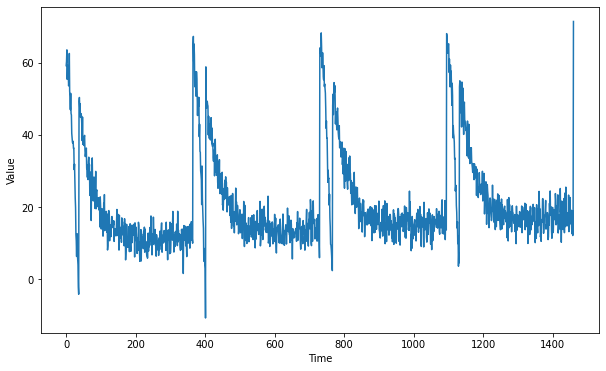

In [61]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Splitting the data

Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [62]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Processing the data

As you saw on the lectures you can feed the data for training by creating a dataset with the appropiate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. To do so complete the `windowed_dataset` function below.

Notice that this function receives a `series`, `window_size`, `batch_size` and `shuffle_buffer` and the last three of these default to the "global" values defined earlier.

Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) about `TF Datasets` if you need any help.

Explanations of prefetch https://cs230.stanford.edu/blog/datapipeline/#best-practices 

In [63]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    ### START CODE HERE
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Split it into the features and labels
    dataset = dataset.map(lambda w: (w[:-1], w[-1]))
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    ### END CODE HERE
    
    return dataset

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Hint:
- You will only need `Dense` layers.
- Do not include `Lambda` layers. These are not required and are incompatible with the `HDF5` format which will be used to save your model for grading.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.

### Find LR

In [64]:

# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(10, input_shape=[G.WINDOW_SIZE], activation="relu"), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(1)
    ]) 

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 50))

# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=0.9))

# Train it
history = model.fit(dataset, epochs=400, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

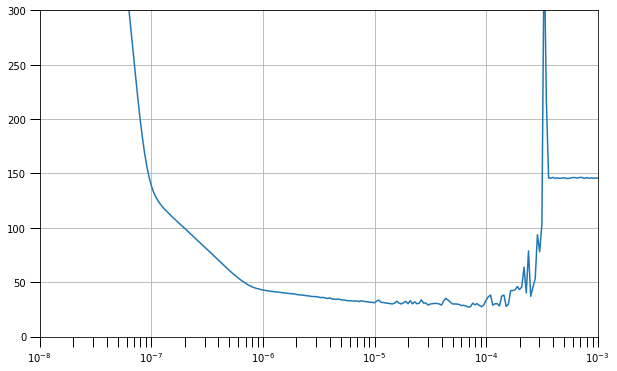

In [65]:

# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(400) / 50))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

### Create the Model with the found learning rate

In [66]:
def create_model(window_size=G.WINDOW_SIZE, lr=1e-6, momentum=0.9):

    ### START CODE HERE

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(1)
    ]) 

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum))
    
    ### END CODE HERE

    return model

In [76]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

tf.keras.backend.clear_session()
# Save an instance of the model
model = create_model(lr=4e-6)

# Train it
history = model.fit(dataset, epochs=150, verbose=0)

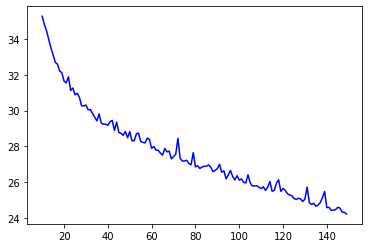

In [77]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs[10:], loss[10:], 'b', label='Training Loss')
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [78]:
def generate_forecast2(model, series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    results = forecast.squeeze()
    return results

In [79]:
# def generate_forecast1(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
#     forecast = []
#     for time in range(len(series) - window_size):
#         forecast.append(model.predict(series[time:time + window_size][np.newaxis], verbose=0))

#     forecast = forecast[split_time-window_size:]
#     results = np.array(forecast)[:, 0, 0]
#     return results

In [80]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

11/11 [==============================] - 0s 12ms/step


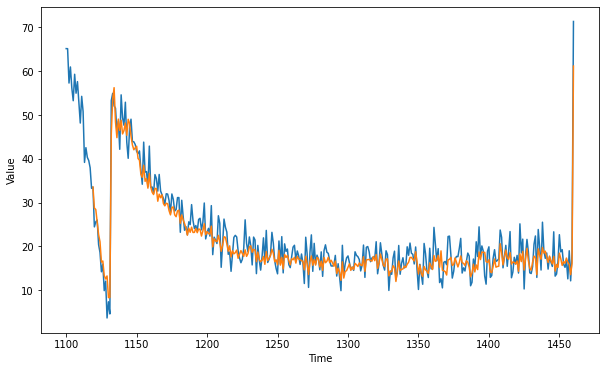

In [81]:
# Save the forecast
dnn_forecast = generate_forecast2(model, series_valid)

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid[G.WINDOW_SIZE-1:], dnn_forecast)

In [82]:
mse, mae = compute_metrics(series_valid[G.WINDOW_SIZE-1:], dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 7.10, mae: 2.05 for forecast


In [74]:
model.save('my_model.h5')